<a href="https://colab.research.google.com/github/riaindrawati/TensorFlow-Image-Classification/blob/main/ImageDetectionTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial Training Image Classification Spesial Buat Miu
Tutorial image classification ini menggunakan framework TensorFlow. Terdapat 4 langkah utama dalam tutorial ini yaitu sebagai berikut:

1. Data Scraping.
2. Data Pre-processing.
3. Model Training.
4. Proses Deteksi atau Inference.

## 0. Setting Parameter Project, Instalasi dan import library
Berikut adalah library yang digunakan dalam project ini.
Pada bagian ini, anda juga dapat menyetting parameter project.

In [ ]:
class Config:
  tipe_objek = "flower"
  objek_yang_digunakan = ["tulip", "rose", "sakura", "sunflower"]
  jumlah_gambar_per_objek = 100
  tinggi_gambar = 180 # tinggi dan lebar gambar dalam pixel
  lebar_gambar = 180

  training_batch_size = 16 # nilai lebih besar mempercepat proses training
                           # nilai lebih kecil mengurangi overfitting

  dataset_split = 0.2 # membagi dataset untuk training dan validasi.
                      # 0.2 -> 20% untuk validasi
                      #        80% untuk testing

  epochs = 25 # jumlah epoch atau perulangan dalam proses training

In [ ]:
!pip install duckduckgo-search # data scraping
from duckduckgo_search import DDGS
import matplotlib.pyplot as plt # menampilkan grafik
import numpy as np
import PIL # image pre-processing
from PIL import Image
import tensorflow as tf # training dan inference model AI
import pathlib
import os
import requests # download file gambar
import imghdr # untuk proses data cleansing
import traceback

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 1. Data Scraping dan Pre-processing
_Data scraping_ adalah proses pengumpulan data dari internet secara otomatis dengan bantuan program. Kita cukup menentukan _keyword_ dari data yang ingin dicari dan program akan mencari dan mendownloadnya secara otomatis. Proses data scraping pada project ini menggunakan library ```duckduckgo-search```.

In [ ]:
!rm -rf /content/dataset # hapus dataset sebelumnya

class ImageScrapper: # class ImageScrapper untuk mencari gambar
  def __init__(self, images):
    self.images = images
    self.searchHelper = DDGS(timeout = 30)

    for i in self.images: # buat folder dataset jika belum ada
      if not os.path.exists(f"dataset/{i}"):
        os.makedirs(f"dataset/{i}")

  def getLinks(self): # fungsi untuk mendapatkan link gambar
    links = []
    for keyword in self.images:
      # perintah untuk mencari gambar dari web.
      results = self.searchHelper.images(
          keywords = keyword + Config.tipe_objek,
          max_results = Config.jumlah_gambar_per_objek,
          type_image = 'photo', size = 'medium'
      )

      imageLinks = [img['image'] for img in results] # ambil link gambar
      links.append({ 'label': keyword, 'links' : imageLinks })
    return links

def downscale(img): # fungsi untuk memperkecil ukuran gambar
  im = Image.open(img)
  width, height = im.size
  if height < width:
    im = im.crop(((width - height)/2, 0, width - (width - height)/2, height))
  elif width < height:
    im = im.crop((0, (height - width)/2, width, height - (height - width)/2))
  im.thumbnail(exportSize, Image.Resampling.LANCZOS)
  im.save(img, "JPEG")


scrapper = ImageScrapper(Config.objek_yang_digunakan)
links = scrapper.getLinks()
exportSize = (Config.lebar_gambar, Config.tinggi_gambar)

for i in links: # download dan perkecil setiap gambar
  n = 0
  for j in i['links']:
    n += 1
    filePath = f"dataset/{i['label']}/{i['label']}_{n}.{j.split('.')[-1]}"
    try:
      # simpan gambar ke dalam file
      file = open(filePath, "wb")
      imageBinary = requests.get(j.replace(" ", "%20"), timeout = 30).content
      file.write(imageBinary)
      file.close()
      downscale(filePath) # perkecil ukuran resolusi gambar
      print(imghdr.what(filePath), filePath)
    except:
      try:
        os.remove(filePath)
      except:
        pass


jpeg dataset/tulip/tulip_1.jpg
jpeg dataset/tulip/tulip_2.jpg
jpeg dataset/tulip/tulip_3.jpg
jpeg dataset/tulip/tulip_4.jpg
jpeg dataset/tulip/tulip_5.jpg
jpeg dataset/tulip/tulip_6.jpg
jpeg dataset/tulip/tulip_7.jpg
jpeg dataset/tulip/tulip_9.jpg
jpeg dataset/tulip/tulip_10.jpg
jpeg dataset/tulip/tulip_11.jpg
jpeg dataset/tulip/tulip_12.jpg
jpeg dataset/tulip/tulip_13.jpg
jpeg dataset/tulip/tulip_14.JPG
jpeg dataset/tulip/tulip_16.jpg
jpeg dataset/tulip/tulip_17.jpg
jpeg dataset/tulip/tulip_18.jpg
jpeg dataset/tulip/tulip_19.jpg
jpeg dataset/tulip/tulip_20.jpg
jpeg dataset/tulip/tulip_21.jpg
jpeg dataset/tulip/tulip_22.webp?b=1&s=170667a&w=0&k=20&c=X2OwUy-brf374FihO8KcCj0-TbJrZxtpti3d7SymhHw=
jpeg dataset/tulip/tulip_23.jpg
jpeg dataset/tulip/tulip_24.jpg
jpeg dataset/tulip/tulip_25.jpg
jpeg dataset/tulip/tulip_26.jpg
jpeg dataset/tulip/tulip_27.jpg
jpeg dataset/tulip/tulip_28.jpg?width=940&height=940
jpeg dataset/tulip/tulip_29.jpg
jpeg dataset/tulip/tulip_30.jpg
jpeg dataset/tulip/t

Bagian _data pre-processing_ diproses oleh kodingan di bawah ini. Proses data cleansing dilakukan dengan menghapus file gambar yang tidak dapat dibuka.

In [ ]:
data_dir = pathlib.Path('dataset').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
from pathlib import Path
import imghdr

img_link=list(data_dir.glob('*/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)
    if not find_img:
        count_num+=1
        os.remove(str(lnk))


Bagian _data augmentation_ adalah teknik untuk menambah jumlah dataset agar jumlahnya lebih banyak dengan memodifikasi gambar yang sama (misalnya diputar dan dibalik).

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(
      "horizontal",
      input_shape = (
        Config.tinggi_gambar,
        Config.lebar_gambar,
        3
      )
    ),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


Koding program di bawah ini berfungsi untuk memecah dataset menjadi dua bagian yaitu ```training dataset``` dan ```testing dataset atau validation```.

In [ ]:
batch_size = Config.training_batch_size
img_height = Config.tinggi_gambar
img_width = Config.lebar_gambar

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = Config.dataset_split,
    subset = "training",
    seed = 123, # angka random untuk mengacak pembagian dataset
    image_size = (img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = Config.dataset_split,
    subset = "validation",
    seed = 123, # angka random untuk mengacak pembagian dataset
    image_size = (img_height, img_width),
    batch_size = batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 306 files belonging to 4 classes.
Using 245 files for training.
Found 306 files belonging to 4 classes.
Using 61 files for validation.
['rose', 'sakura', 'sunflower', 'tulip']


Tampilkan gambar dari setiap kategori untuk memastikan bahwa dataset sudah sesuai.

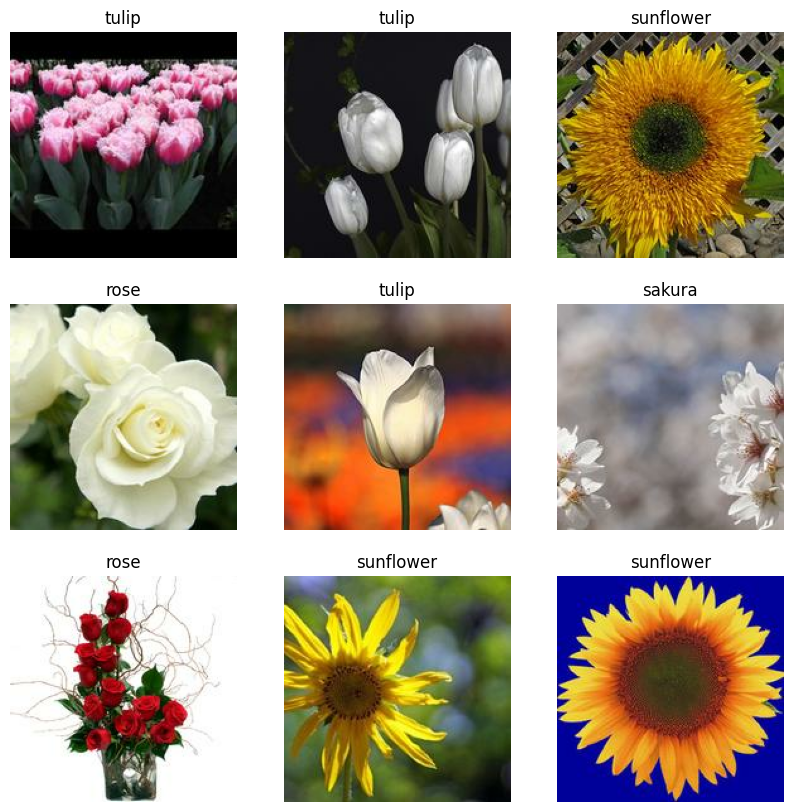

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2. Proses Training Model AI _Image Classification_
Dalam proses ini, model AI 'dilatih' untuk mengenali dan mengklasifikasikan gambar. Metode yang digunakan adalah **unsupervised learning** karena model AI mempelajari dan mengenali setiap kategori secara otomatis melalui nama folder dataset yang telah ada. Tidak ada campur tangan manusia selama proses training berlangsung.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # AUTOTUNE berfungsi untuk mengatur beberapa
                            # settingan yang umum dipakai secara otomatis.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# melakukan normalisasi dataset dengan mengubah skala 0 - 255 (8-bit RGB)
# menjadi 0 - 1.0 agar lebih mudah diproses.
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

# layer dari model AI, dapat disesuaikan dengan kebutuhan
# layer yang tepat dapat meningkatkan kemampuan deteksi model AI
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

# compile model
model.compile(
    optimizer='adam', # adam adalah nama algoritma optimasi model AI
                      # adam adalah singkatan dari adaptive moment estimation

    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] # gunakan akurasi sebagai acuan dari proses training
)

model.summary() # tampilkan summary dari model, menampilkan jumlah parameter
                # model AI beserta layer yang digunakan

epochs = Config.epochs

# perintah model.fit() adalah untuk memulai proses training
history = model.fit(train_ds, validation_data = val_ds, epochs=epochs)


0.0 1.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                         

Kodingan di bawah ini menunjukkan hasil dari proses training. Terdapat dua grafik yang dihasilkan yaitu **grafik akurasi** dan **grafik loss**.
Loss umumnya berbanding terbalik dengan akurasi, sehingga grafiknya bisa dibilang mirip namun terbalik.

Cara membaca grafik hasil training adalah sebagai berikut.

1. Perhatikan garis berwarna biru dan kuning.
2. Garis biru adalah grafik ```training accuracy``` dan garis kuning adalah grafik ```validation accuracy```. Umumnya, ```training accuracy``` hampir selalu naik. Sedangkan ```validation accuracy``` grafiknya turun-naik. Grafik loss memiliki bentuk yang mirip dengan grafik accuracy namun terbalik.
3. Bentuk ideal dari ```validation accuracy``` adalah terus naik dan tidak fluktuatif. Sehingga perlu diperhatikan bentuk grafiknya.
4. Bentuk grafik ```validation accuracy``` yang naik secara stabil menandakan model AI yang dibuat sudah cukup bagus.

Cara mengetahui apakah suatu model AI sudah bagus, overfit, atau underfit.

1. Jika bentuk grafiknya seperti ini, maka model AI overfit. Perhatikan grafik kuning sangat fluktuatif dan hasil akhir malah lebih rendah dari nilai akurasi di awal training. Kondisi overfit dapat diatasi dengan menambah jumlah dan variasi dataset. Nilai ```batch size``` juga dapat mempengaruhi overfit.

 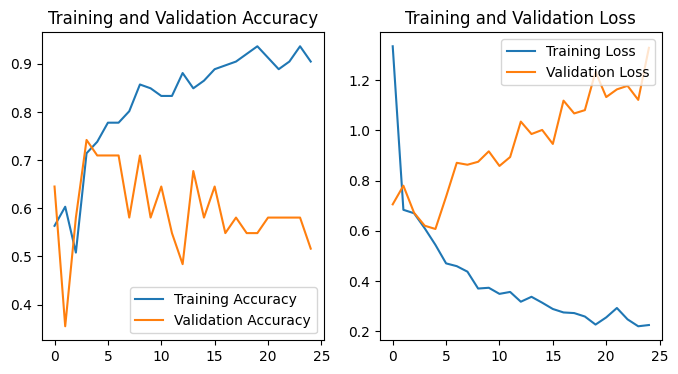


2. Jika grafiknya seperti di bawah ini, makan model bisa dikatakan mengalami underfit. Kondisi underfit adalah kondisi di mana grafik akurasi memiliki pontensi untuk naik namun proses training sudah selesai. Seperti pada gambar di bawah. Solusi dari underfit umumnya cukup dengan menambah nilai epoch.

  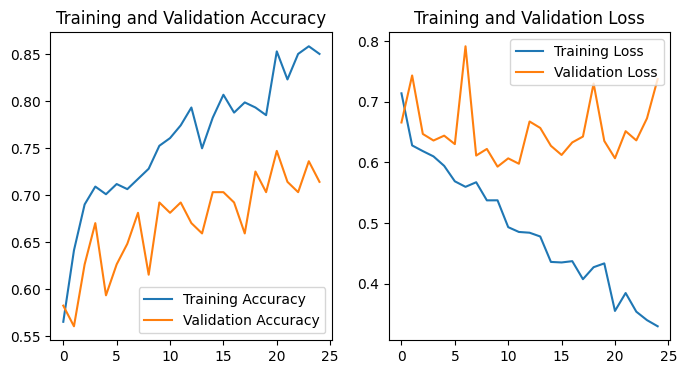


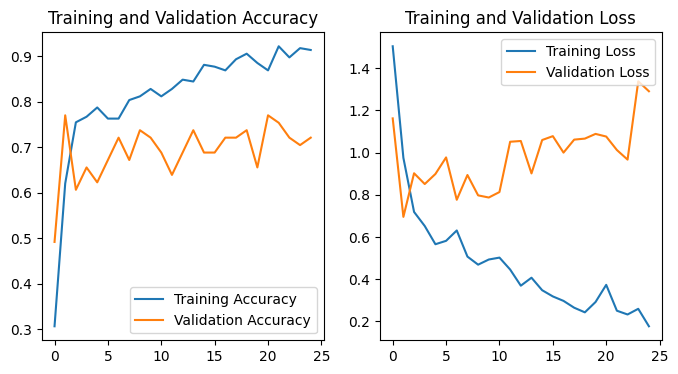

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img_path = list(data_dir.glob('tulip/*'))[6]
img = tf.keras.utils.load_img(img_path, target_size = (img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 30ms/step
tf.Tensor([0.5395806  0.46041942], shape=(2,), dtype=float32)
This image most likely belongs to rose with a 53.96 percent confidence.
